In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.utils import img_to_array

In [4]:
def preprocess_image(image_path, target_size=(224, 224)):
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    if img.shape[-1] == 4:  # Check if image has 4 channels
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    old_size = img.shape[:2]
    ratio = float(target_size[0]) / max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    resized_img = cv2.resize(img, (new_size[1], new_size[0]))

    delta_w = target_size[1] - new_size[1]
    delta_h = target_size[0] - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    padded_img = cv2.copyMakeBorder(resized_img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return img_to_array(padded_img) / 255.0

def process_dataset(dataset_dir):
    data = []
    labels = []
    class_names = sorted(os.listdir('Misc/logos'))
    for label, bank_name in enumerate(class_names):
        bank_dir = os.path.join(dataset_dir, bank_name)
        for file in os.listdir(bank_dir):
            if file.endswith('.png'):
                img_path = os.path.join(bank_dir, file)
                img = preprocess_image(img_path)
                data.append(img)
                labels.append(label)
    return np.array(data), np.array(labels), class_names

In [5]:
image_size = (224, 224)
batch_size = 64
num_classes = len(os.listdir('Misc/logos'))

data, labels, class_names = process_dataset('Misc/logos')

In [6]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(274, 224, 224, 3) (69, 224, 224, 3) (274,) (69,)


In [7]:
# Modify the data augmentation to be more aggressive
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    shear_range=0.3,
    fill_mode='nearest',
    channel_shift_range=30.0,
    rescale=1./255
)

# Modify the validation generator to include rescaling
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [8]:
# Define the CNN model
def create_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(256, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        MaxPooling2D(pool_size=(2, 2)),
        
        Flatten(),
        Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        Dropout(0.5),
        Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)), 
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

model = create_cnn((224, 224, 3), num_classes)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
5/5 [==============================] - 14s 3s/step - loss: 15.2393 - accuracy: 0.1168 - val_loss: 11.1180 - val_accuracy: 0.1594
Epoch 2/50
5/5 [==============================] - 12s 2s/step - loss: 9.7025 - accuracy: 0.1533 - val_loss: 7.5768 - val_accuracy: 0.1594
Epoch 3/50
5/5 [==============================] - 13s 3s/step - loss: 7.3536 - accuracy: 0.1569 - val_loss: 6.7767 - val_accuracy: 0.1594
Epoch 4/50
5/5 [==============================] - 13s 2s/step - loss: 6.7443 - accuracy: 0.1058 - val_loss: 6.2177 - val_accuracy: 0.1594
Epoch 5/50
5/5 [==============================] - 12s 2s/step - loss: 6.1424 - accuracy: 0.1350 - val_loss: 5.5189 - val_accuracy: 0.1594
Epoch 6/50
5/5 [==============================] - 14s 3s/step - loss: 5.3710 - accuracy: 0.1569 - val_loss: 4.9134 - val_accuracy: 0.1304
Epoch 7/50
5/5 [==============================] - 13s 2s/step - loss: 4.9076 - accuracy: 0.1314 - val_loss: 4.5628 - val_accuracy: 0.1594
Epoch 8/50
5/5 [================

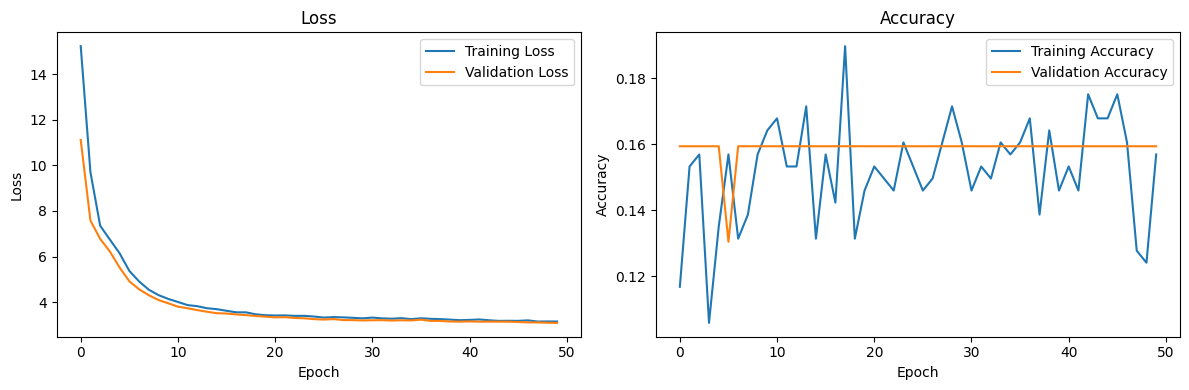

In [10]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()